# Vehicle Coupon Recommendation
#### Author: Abhinav Sattiraju
#### Dataset: https://archive.ics.uci.edu/ml/datasets/in-vehicle+coupon+recommendation, from UCI ML Repository
#### Summary: 
This project aims to explore relationships between the data in the UCI in-vehicle coupon dataset and use gained insights to train a model that can accurately predict whether the driver will accept the coupon. The project incorporates initial inspection of the data, exploratory data analysis, data cleaning and processing, and model training and evaluation to accomplish these goals.

### Part 1: Imports and Initial Inspection of Data

In [148]:
import numpy as np
import pandas as pd
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance

import warnings
warnings.filterwarnings('ignore')

import pickle

In [149]:
df = pd.read_csv('data.csv')
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [150]:
print(df.info())

print("\n Shape = " + str(df.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [151]:
#information about unique values for each column
values = {'col':[],'unique':[]}

for col in df.columns:
    values['col'].append(col)
    values['unique'].append(df[col].unique())

values = pd.DataFrame(values)

values

,col,unique
0,destination,"[No Urgent Place, Home, Work]"
1,passanger,"[Alone, Friend(s), Kid(s), Partner]"
2,weather,"[Sunny, Rainy, Snowy]"
3,temperature,"[55, 80, 30]"
4,time,"[2PM, 10AM, 6PM, 7AM, 10PM]"
5,coupon,"[Restaurant(<20), Coffee House, Carry out & Ta..."
6,expiration,"[1d, 2h]"
7,gender,"[Female, Male]"
8,age,"[21, 46, 26, 31, 41, 50plus, 36, below21]"
9,maritalStatus,"[Unmarried partner, Single, Married partner, D..."


We can see that this dataset consists of mostly categorical data, let's try to see if we can do some initial feature processing before visualizing the data.

In [152]:
df.income.value_counts()

$25000 - $37499     2013
$12500 - $24999     1831
$37500 - $49999     1805
$100000 or More     1736
$50000 - $62499     1659
Less than $12500    1042
$87500 - $99999      895
$75000 - $87499      857
$62500 - $74999      846
Name: income, dtype: int64

In [153]:
def process_income(row):
    if '-' in row:
        lower = int(row[0:row.index('-')].strip()[1:])
        upper = int(row[row.index('-')+3:])
        return (lower + upper) / 2  #Returns center of range of incomes as numeric value
    else:
        if 'More' in row:
            return 106250
        else:
            return 6250

In [154]:
#Convert the income ranges to average income numeric values
df['income'] = df.apply(lambda x: process_income(x.income),axis=1)

In [155]:
df.age.value_counts()

21         2653
26         2559
31         2039
50plus     1788
36         1319
41         1093
46          686
below21     547
Name: age, dtype: int64

In [156]:
#Function to convert the age column to categories
def process_age(row):
    if 'below21' in row:
        return 'teens'
    elif '2' in row:
        return 'twenties'
    elif '3' in row:
        return 'thirties'
    elif '4' in row:
        return 'forties'
    else:
        return 'elderly'

In [157]:
df['age'] = df.apply(lambda x: process_age(x.age),axis=1)

In [158]:
df['temperature'].replace({30:'cold',55:'middle',80:'hot'},inplace=True)  # Make this feature categorical as well

In [159]:
df.drop('toCoupon_GEQ5min',axis=1,inplace=True) # Drop this feature as all rows have same value 

In [160]:
df.drop('occupation',axis=1,inplace=True)  # Drop this feature as too many categories to deal with in future

### Part 2: Exploratory Data Analysis

Explore relationships between some features and the output label.

Text(0.5, 1.0, 'Value Counts of Output Classes')

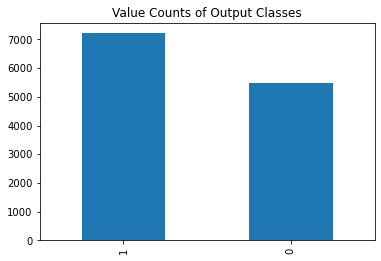

In [161]:
df.Y.value_counts().plot(kind='bar')
plt.title('Value Counts of Output Classes')

We see that these are slightly imbalanced class counts, but not too imbalanced.

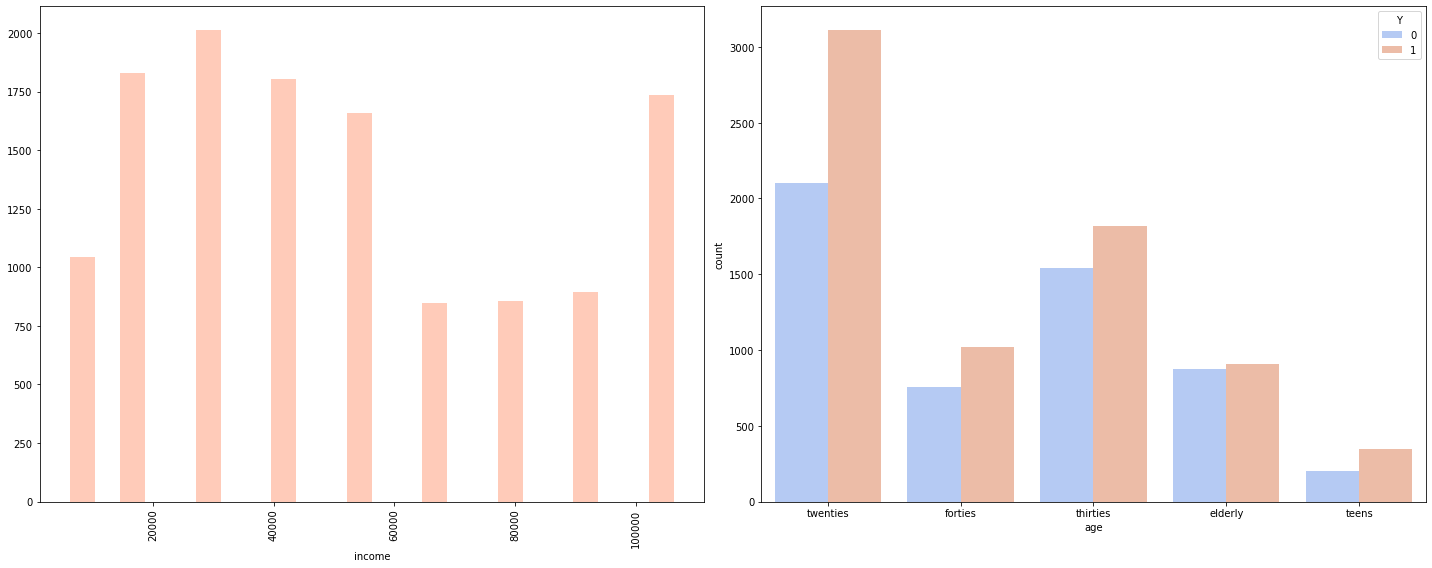

In [162]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
for t in axes[0].get_xticklabels():
    t.set_rotation(90)

sns.distplot(df['income'],ax=axes[0],color='coral',kde=False)
sns.countplot(x='age',data=df,ax=axes[1],hue='Y',palette='coolwarm')

plt.tight_layout()

Text(0.5, 1.0, 'Income vs Coupon acceptances')

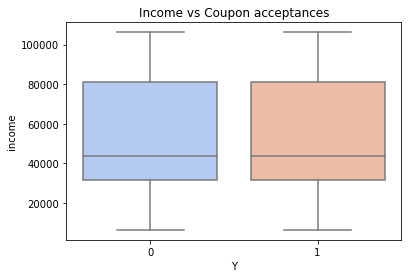

In [163]:
sns.boxplot(x='Y',y='income',data=df,palette='coolwarm')
plt.title("Income vs Coupon acceptances")

From the above graph, it looks like income may not be a good predictor of coupon acceptances.

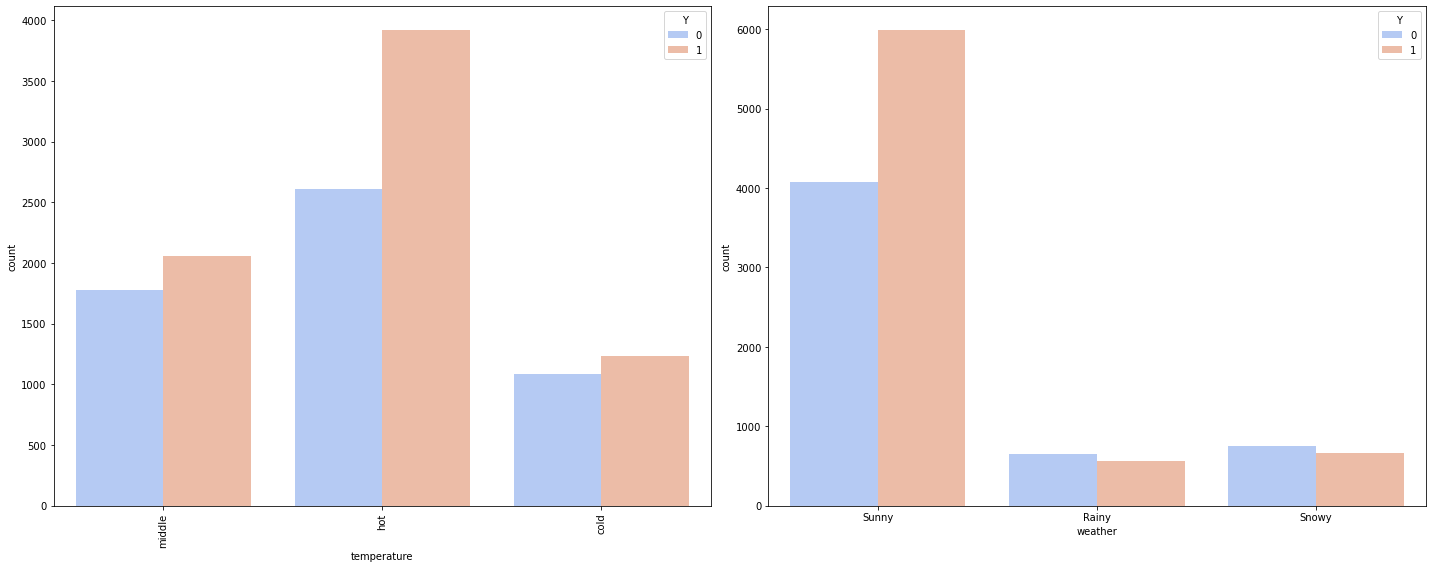

In [164]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
for t in axes[0].get_xticklabels():
    t.set_rotation(90)

sns.countplot(x='temperature',data=df,ax=axes[0],hue='Y',palette='coolwarm')
sns.countplot(x='weather',data=df,ax=axes[1],hue='Y',palette='coolwarm')

plt.tight_layout()

From both of the above graphs, we can deduce that the best weather conditions (Hot and Sunny) are associated with the greatest ratio of coupon acceptances to coupon rejections, which makes sense on an intuitive level.

Text(0.5, 1.0, 'Distribution of coupon acceptances with regards to passenger status')

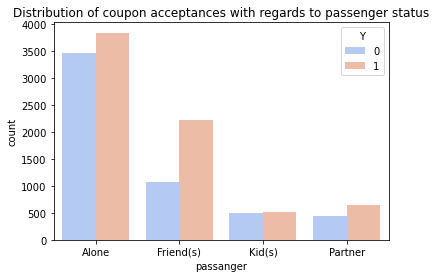

In [165]:
sns.countplot(x='passanger',data=df,hue='Y',palette='coolwarm')
plt.title("Distribution of coupon acceptances with regards to passenger status")

We can see from the above graph that having a friend as a passenger is correlated with higher chances of getting a coupon accepted, more so than having a kid or partner as a passenger.

AxesSubplot(0.125,0.125;0.775x0.755)


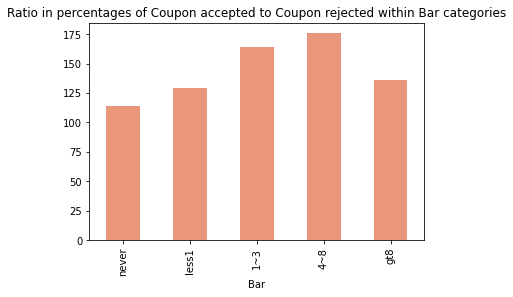

AxesSubplot(0.125,0.125;0.775x0.755)


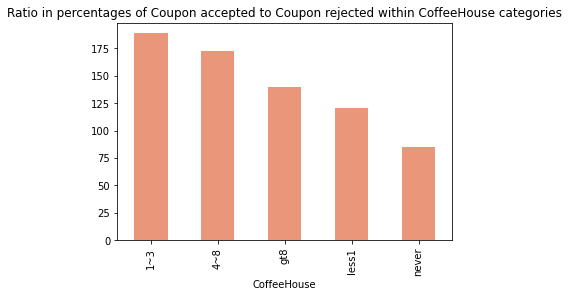

AxesSubplot(0.125,0.125;0.775x0.755)


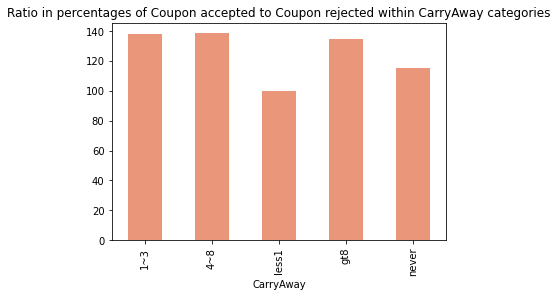

AxesSubplot(0.125,0.125;0.775x0.755)


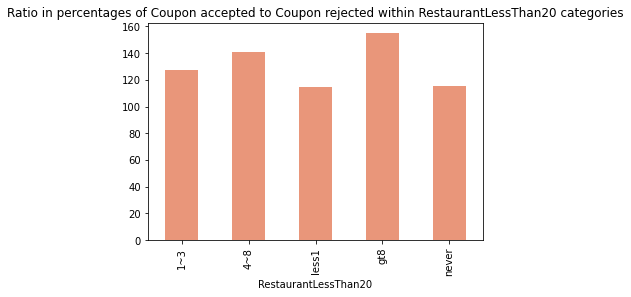

AxesSubplot(0.125,0.125;0.775x0.755)


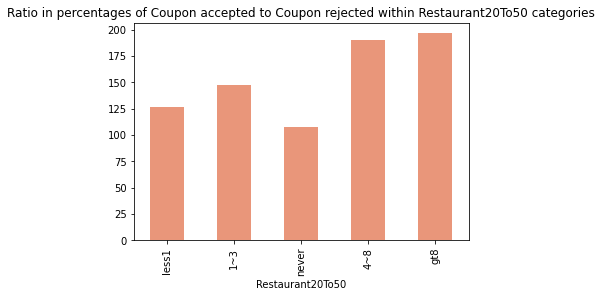

In [166]:
# We want to compare the ratio of coupon acceptances to coupon rejections for the different categories among
# the various coupon scenarios (Bar, CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50)

for coupon in ['Bar','CoffeeHouse','CarryAway','RestaurantLessThan20','Restaurant20To50']:
    data = df.groupby('Y')[coupon].value_counts()
    data = data[1] * 100 / data[0]
    plt.title('Ratio in percentages of Coupon accepted to Coupon rejected within ' + coupon + ' categories')
    print(data.plot(kind='bar',color='darksalmon'))
    plt.show()


In [167]:
df.groupby('Y')['expiration'].value_counts()

Y  expiration
0  2h            2819
   1d            2655
1  1d            4436
   2h            2774
Name: expiration, dtype: int64

The above groupby operation illustrates that coupons are more likely to get accepted if valid for a longer period of time.

In [168]:
df.groupby('Y')['destination'].value_counts()

Y  destination    
0  No Urgent Place    2301
   Home               1598
   Work               1575
1  No Urgent Place    3982
   Home               1639
   Work               1589
Name: destination, dtype: int64

Now, explore relationships between features themselves.

Text(0.5, 1.0, 'Correlation Heatmap')

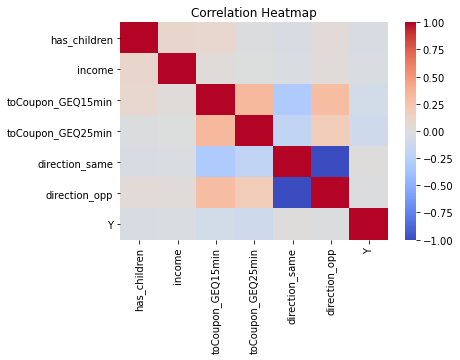

In [169]:
sns.heatmap(df.corr(),cmap='coolwarm')
plt.title("Correlation Heatmap")

We see that direction_same and direction_opp appear perfectly correlated. Let's investigate this.

In [170]:
print(df['direction_opp'].value_counts())
print(df['direction_same'].value_counts())

df.drop('direction_same',axis=1,inplace=True)  #Features are perfect opposites of each other

1    9960
0    2724
Name: direction_opp, dtype: int64
0    9960
1    2724
Name: direction_same, dtype: int64


Text(0.5, 1.0, 'Education vs Income')

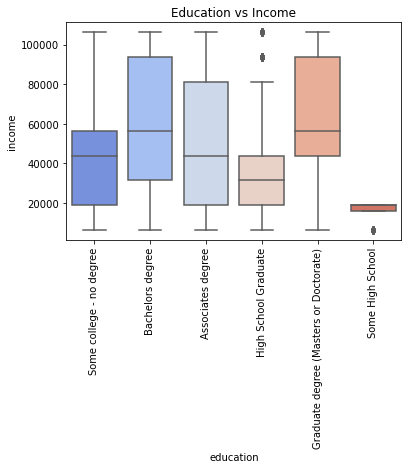

In [171]:
sns.boxplot(x='education',y='income',data=df,palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Education vs Income")

The above graph illustrates the more obvious relationship between highest level of education and income level.

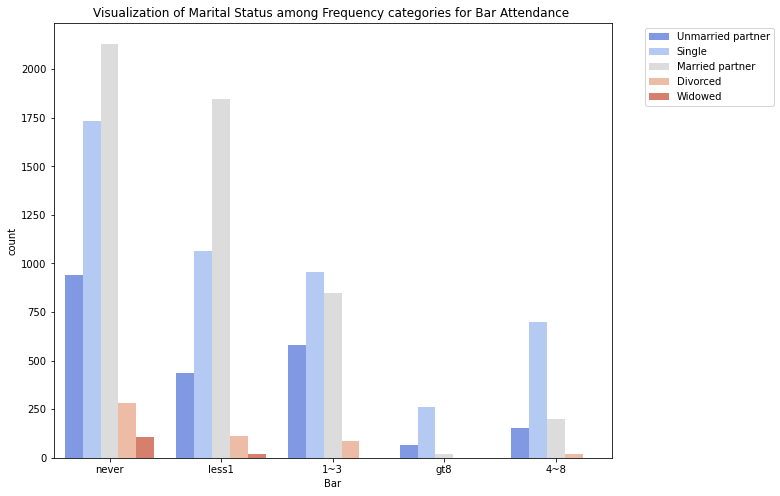

In [173]:
plt.figure(figsize=(10,8))
sns.countplot(x='Bar',data=df,hue='maritalStatus',palette='coolwarm')
plt.title('Visualization of Marital Status among Frequency categories for Bar Attendance ')
plt.legend(bbox_to_anchor=(1.05, 1))

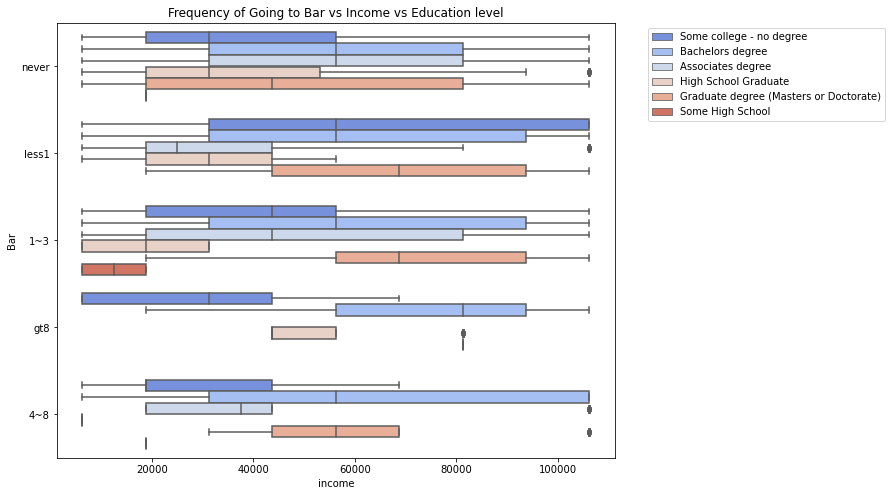

In [115]:
plt.figure(figsize=(10,8))
sns.boxplot(x='income',y='Bar',data=df,palette='coolwarm',hue='education')
plt.title('Frequency of Going to Bar vs Income vs Education level')
plt.legend(bbox_to_anchor=(1.05, 1))

The above graph illustrates some interesting differences among both income level and education level with respect to the frequency of going to the bar each month. Interestingly, the highest median income occurs for Bachelor's Degree recipients who go to the bar greater than 8 times each month. Also, those with graduate degrees aren't recorded going to the bar greater than 8 times a month. 

Income vs. CoffeeHouse


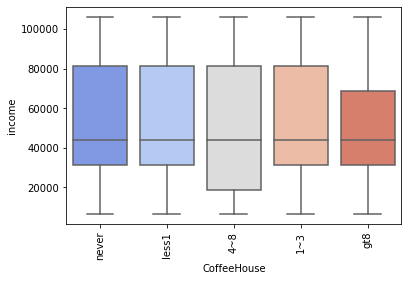

Income vs. CarryAway


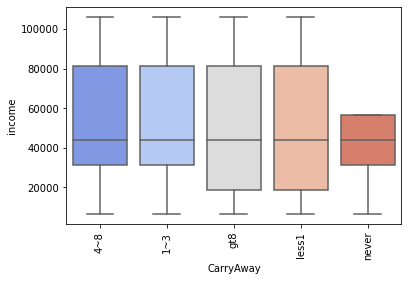

Income vs. RestaurantLessThan20


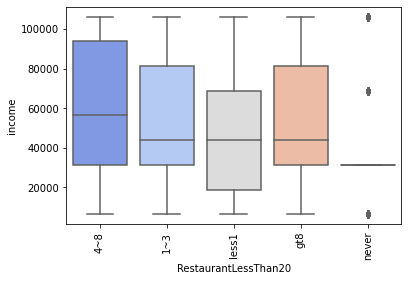

Income vs. Restaurant20To50


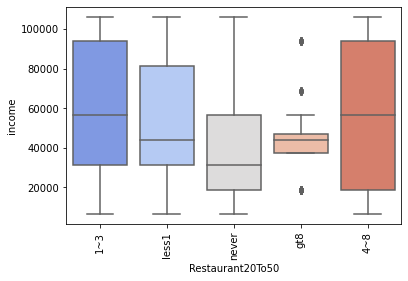

In [116]:
# Visualize income levels among categories for various coupon designations

for coupon in ['CoffeeHouse','CarryAway','RestaurantLessThan20','Restaurant20To50']:
    print("Income vs. " + coupon)
    sns.boxplot(x=coupon,y='income',data=df,palette='coolwarm')
    plt.xticks(rotation=90)
    plt.show()

### Part 3: Data Cleaning and Imputation

Null value imputation for following features:
- car
- Bar
- CoffeeHouse
- CarryAway
- RestaurantLessThan20
- Restaurant20To50

In [117]:
def get_prct_null(df):
    percent_null = (df.isnull().sum() * 100) / len(df)
    percent_null = percent_null.sort_values()
    percent_null = percent_null[percent_null > 0]
    return percent_null

Text(0, 0.5, 'Percent null')

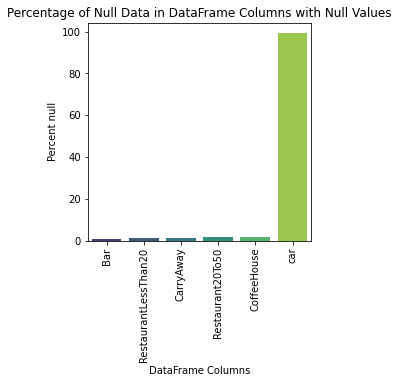

In [118]:
percent_null = get_prct_null(df)

plt.figure(figsize=(4,4))
sns.barplot(x=percent_null.index,y=percent_null,palette='viridis')
plt.xticks(rotation=90);

plt.title('Percentage of Null Data in DataFrame Columns with Null Values')
plt.xlabel('DataFrame Columns')
plt.ylabel('Percent null')

The car feature has too many null values, so we drop that feature below.

In [119]:
df.drop('car',axis=1,inplace=True)

Text(0, 0.5, 'Percent null')

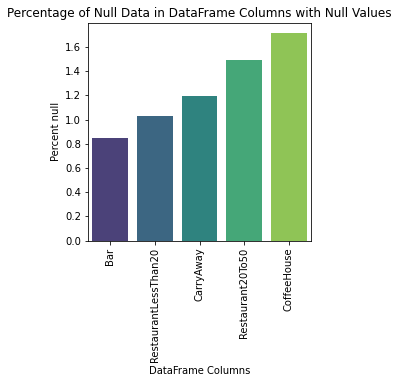

In [120]:
percent_null = get_prct_null(df)

plt.figure(figsize=(4,4))
sns.barplot(x=percent_null.index,y=percent_null,palette='viridis')
plt.xticks(rotation=90);

plt.title('Percentage of Null Data in DataFrame Columns with Null Values')
plt.xlabel('DataFrame Columns')
plt.ylabel('Percent null')

Let's remove all the rows that have all of the above features as null:

In [121]:
remove = df[(df.Bar.isnull()) & (df.CarryAway.isnull())
       & (df.RestaurantLessThan20.isnull()) & (df.RestaurantLessThan20.isnull()) & (df.Restaurant20To50.isnull())
        & (df.CoffeeHouse.isnull())]

df = df.iloc[[index not in remove.index for index in range(df.shape[0])]]

In [122]:
df = df[df.Bar.notnull()] # Drop the remaining 65 missing values of Bar Feature

Text(0, 0.5, 'Percent null')

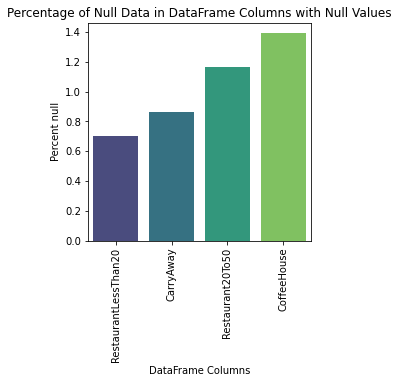

In [123]:
percent_null = get_prct_null(df)

plt.figure(figsize=(4,4))
sns.barplot(x=percent_null.index,y=percent_null,palette='viridis')
plt.xticks(rotation=90);

plt.title('Percentage of Null Data in DataFrame Columns with Null Values')
plt.xlabel('DataFrame Columns')
plt.ylabel('Percent null')

In [125]:
df.groupby('education')['CoffeeHouse'].value_counts()

education                               CoffeeHouse
Associates degree                       less1           437
                                        1~3             278
                                        never           263
                                        4~8             154
Bachelors degree                        never          1226
                                        less1          1092
                                        1~3             996
                                        4~8             709
                                        gt8             256
Graduate degree (Masters or Doctorate)  1~3             560
                                        4~8             417
                                        gt8             322
                                        less1           301
                                        never           252
High School Graduate                    never           279
                                        less1   

In [124]:
# Impute Restaurant20to50 with median Income value for each group
# Impute CoffeeHouse with the most common value per education level as shown above.

df.replace({np.nan:np.nan},inplace=True)

for index, row in df.iterrows():
    if type(row['Restaurant20To50']) == float:
        if row['income'] == 56249.5:
            if randint(0,1) == 0:
                df.at[index, 'Restaurant20To50'] = '1~3'
            else:
                df.at[index, 'Restaurant20To50'] = '4~8'
        elif row['income'] == 43749.5:
            if randint(0,1) == 0:
                df.at[index, 'Restaurant20To50'] = 'less1'
            else:
                df.at[index, 'Restaurant20To50'] = 'gt8'
        else:
            df.at[index, 'Restaurant20To50'] = 'never'
            
    if type(row['CoffeeHouse']) == float:
        if row['education'] in ['Associates degree','Some college - no degree']:
            df.at[index, 'CoffeeHouse'] = 'less1'
        elif row['education'] in ['Bachelors degree','High School Graduate']:
            df.at[index, 'CoffeeHouse'] = 'never'
        elif row['education'] in ['Graduate degree (Masters or Doctorate)','Some High School']:
            df.at[index, 'CoffeeHouse'] = '1~3'  
        
df['RestaurantLessThan20'].fillna('never',inplace=True)
df['CarryAway'].fillna('never',inplace=True)

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12577 entries, 0 to 12683
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   destination           12577 non-null  object 
 1   passanger             12577 non-null  object 
 2   weather               12577 non-null  object 
 3   temperature           12577 non-null  object 
 4   time                  12577 non-null  object 
 5   coupon                12577 non-null  object 
 6   expiration            12577 non-null  object 
 7   gender                12577 non-null  object 
 8   age                   12577 non-null  object 
 9   maritalStatus         12577 non-null  object 
 10  has_children          12577 non-null  int64  
 11  education             12577 non-null  object 
 12  income                12577 non-null  float64
 13  Bar                   12577 non-null  object 
 14  CoffeeHouse           12577 non-null  object 
 15  CarryAway          

We have no more null values, so let's proceed to converting categorical features to numeric via one-hot encoding.

### Part 4: One-Hot Encoding

In [127]:
income = df['income']

output = df['Y']

df = df.drop('income',axis=1)
df = df.drop('Y',axis=1)


to_add_df = pd.get_dummies(df['destination'],drop_first=True,prefix='destination')

# Gets dummy columns for each column in dataframe, appends it to a new dataframe
for col in df.columns:
    add_df = pd.get_dummies(df[col], drop_first=True,prefix=col)
    to_add_df = pd.concat([add_df,to_add_df],axis=1)

In [129]:
# Concatenates the dummy-column dataframe with the income and output columns

df = pd.concat([to_add_df,income,output],axis=1).reset_index().drop('index',axis=1)

In [130]:
df.head()

,direction_opp_1,toCoupon_GEQ25min_1,toCoupon_GEQ15min_1,Restaurant20To50_4~8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never,RestaurantLessThan20_4~8,RestaurantLessThan20_gt8,RestaurantLessThan20_less1,...,weather_Sunny,passanger_Friend(s),passanger_Kid(s),passanger_Partner,destination_No Urgent Place,destination_Work,destination_No Urgent Place,destination_Work,income,Y
0,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,1,0,43749.5,1
1,1,0,0,0,0,0,0,1,0,0,...,1,1,0,0,1,0,1,0,43749.5,0
2,1,0,1,0,0,0,0,1,0,0,...,1,1,0,0,1,0,1,0,43749.5,1
3,1,0,1,0,0,0,0,1,0,0,...,1,1,0,0,1,0,1,0,43749.5,0
4,1,0,1,0,0,0,0,1,0,0,...,1,1,0,0,1,0,1,0,43749.5,0


In [131]:
df = df.sample(frac=1).reset_index(drop=True) #Shuffles the values in the dataframe

In [132]:
df.shape # Check shape one more time

(12577, 60)

### Part 5: Model Training and Evaluation

In [133]:
X = df.drop('Y',axis=1)
y = df['Y']

###### PCA

In [53]:
pca = PCA(n_components=15)

k = 5
num_per_fold = len(X) // 5

# Manual 5-fold cross validation
for i in range(k):
          
    # Split data into validation and training sets
    val = X.values[i * num_per_fold: (i + 1) * num_per_fold]
    val_output = y.values[i * num_per_fold: (i + 1) * num_per_fold]
    
    train = np.concatenate([X.values[:i * num_per_fold],X.values[(i + 1) * num_per_fold :]],axis=0)
    train_output = np.concatenate([y.values[:i * num_per_fold],y.values[(i + 1) * num_per_fold :]],axis=0)
    
    # Fit a 15 component PCA model on the data and transform the data
    pca.fit(train)
    new_train = pca.transform(train)
    new_val = pca.transform(val)
    
    # Train a base XGBoost Classifier model and print classification report
    new_model = XGBClassifier()

    new_model.fit(new_train,train_output)
    
    val_pred = new_model.predict(new_val)
    
    print(classification_report(val_output,val_pred))


[13:43:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.63      0.57      0.60      1073
           1       0.70      0.75      0.73      1442

    accuracy                           0.68      2515
   macro avg       0.67      0.66      0.66      2515
weighted avg       0.67      0.68      0.67      2515

[13:43:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_m

As we can see, our model didn't perform too well, hovering around 0.68 accuracy with an F1 score for acceptances of 0.73. Let's try fitting a XGBoost Classifier Model with GridSearchCV for hyperparameter tuning and Recursive Feature Elimination for feature selection to increase the accuracy.

In [54]:
models = []

for num in [35,45,59]:
    
    # Construct XGBoost Model and RFE object with internal estimator of Decision Tree
    xgb = XGBClassifier(n_estimators=500,subsample=0.75,colsample_bytree=0.75)
    ft_selector = RFE(estimator=DecisionTreeClassifier(),n_features_to_select=num)

    # Construct a pipeline to prevent data leakage
    steps = [('ft_selector',ft_selector),('xgb',xgb)]
    pipe = Pipeline(steps=steps)

    # Parameters for GridSearch
    params = {'xgb__max_depth':[4,6,8],'xgb__learning_rate':[0.01,0.05,0.1]}

    # Construct GridSearch object, pass in the pipe object
    search_xgb = GridSearchCV(pipe, params, cv=5, scoring='accuracy',n_jobs=-1)

    search_xgb.fit(X.values,y.values)

    models.append(search_xgb)
    
    # Print results
    print(str(num) + ", " + str(search_xgb.best_params_) + ", " + str(search_xgb.cv_results_['mean_test_score'].max()))


[13:47:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
35, {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6}, 0.7518499495870563
[13:52:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
45, {'xgb__learning_rate': 0.05, 'xgb__max_depth': 8}, 0.7665582024545888
[13:57:00] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/wor

Our model did better here, reaching an accuracy higher than 0.76 percent. The third model trained was the best, and we can see that our model did best without RFE when we included all 59 features. Let's visualize the feature importance scores.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

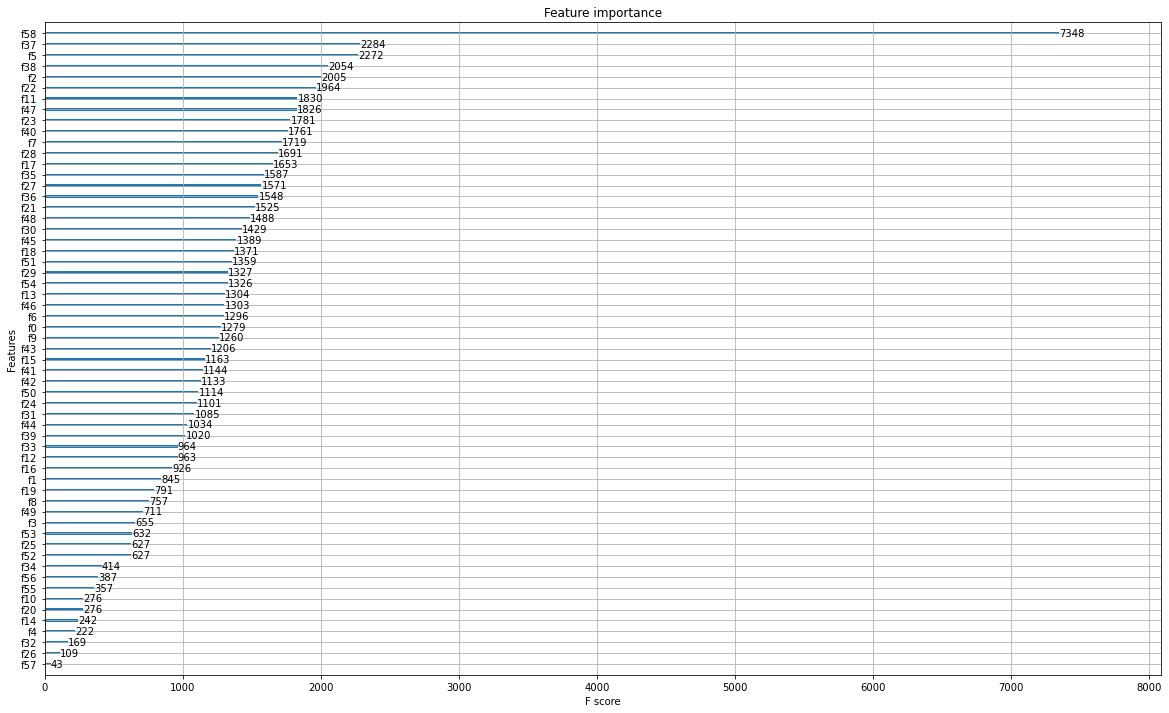

In [55]:
fig, axes = plt.subplots(1, 1, figsize=(20, 12))
plot_importance(models[2].best_estimator_.steps[1][1],ax=axes)

In [56]:
np.sort(models[2].best_estimator_.steps[1][1].feature_importances_)

array([0.00995491, 0.01207737, 0.0121901 , 0.01256615, 0.01324644,
       0.01324936, 0.01341228, 0.01362139, 0.01380609, 0.01426367,
       0.01444509, 0.01445846, 0.01447463, 0.01452167, 0.01463524,
       0.01470939, 0.01482632, 0.01487644, 0.01493652, 0.01497825,
       0.0151042 , 0.01511151, 0.01515661, 0.01521568, 0.0152158 ,
       0.01526489, 0.01542834, 0.01545685, 0.01550641, 0.01552216,
       0.01554084, 0.01555095, 0.01555478, 0.01567215, 0.01567706,
       0.01598524, 0.01646478, 0.01650014, 0.01655077, 0.01667823,
       0.0167012 , 0.01672725, 0.01678251, 0.01770898, 0.01775129,
       0.01788408, 0.01795308, 0.01805352, 0.01834937, 0.01865362,
       0.01919932, 0.02091715, 0.02123194, 0.02239629, 0.02247955,
       0.02424662, 0.02969058, 0.03696394, 0.03790249], dtype=float32)

Based off the graph, let's try to see if we can push our performance by removing the bottom 10 features with the lowest importance scores. We will utilize our prior GridSearchCV model with manual cross-validation and select features via threshold.

##### Feature Selection

In [134]:
y_predictions = []

k = 5
num_per_fold = len(X) // 5

best_model = models[2].best_estimator_.steps[1][1]

for i in range(k):
    
    # Manual cross validation, prepare validation and train sets      
    val = X.values[i * num_per_fold: (i + 1) * num_per_fold]
    val_output = y.values[i * num_per_fold: (i + 1) * num_per_fold]
    
    train = np.concatenate([X.values[:i * num_per_fold],X.values[(i + 1) * num_per_fold :]],axis=0)
    train_output = np.concatenate([y.values[:i * num_per_fold],y.values[(i + 1) * num_per_fold :]],axis=0)
    
    # SelectFromModel object with the given feature importance threshold to remove features with scores less than it
    select = SelectFromModel(best_model,threshold =0.0143,prefit=True)
    
    # Transform train data, basically removes certain features
    new_train = select.transform(train)
    
    new_model = XGBClassifier(n_estimators=500,subsample=0.75,colsample_bytree=0.75,learning_rate=0.05,max_depth=8)
    
    new_model.fit(new_train,train_output)
    
    # Transform the validation data
    new_val = select.transform(val)
    
    y_pred = new_model.predict(new_val)
    
    # Append predictions for this fold into an array containing all folds' predictions
    y_predictions.append(y_pred)

[14:20:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

In [86]:
ypred = np.concatenate([y_predictions[i] for i in range(5)])

In [87]:
print(len(ypred))
y_true = y[:-2]  # Remove last two output rows to align true and predicted outputs for classification report.

12575


In [139]:
print(classification_report(y_true,ypred))   # Very slight improvement across all metrics

              precision    recall  f1-score   support

           0       0.75      0.70      0.72      5420
           1       0.78      0.82      0.80      7155

    accuracy                           0.77     12575
   macro avg       0.77      0.76      0.76     12575
weighted avg       0.77      0.77      0.77     12575



### Part 5: Saving Best Model

We will save our GridSearchCV model here.

In [136]:
file_name = 'final_xgb_model.sav'

In [143]:
pickle.dump(best_model, open(file_name, 'wb'))  #Dumps the model via pickle to .sav file

In [146]:
# Re-opens the model from file

#best_model = pickle.load(open(file_name, 'rb'))